In [1]:
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from script.dataset import get_data
from script.visualization import pretty_hm, pretty_str, savefig_pdf

In [9]:
X, y = get_data(calibrated=True)
hold_types = pd.Categorical(y.hold).categories
people = pd.Categorical(y.person).categories

In [10]:
pca = PCA(n_components=1)
X['PCA1'] = pca.fit_transform(X)
print(f'PCA1 accounts for approximately {pca.explained_variance_ratio_[0] * 100:.0f}% of variance')

PCA1 accounts for approximately 44% of variance


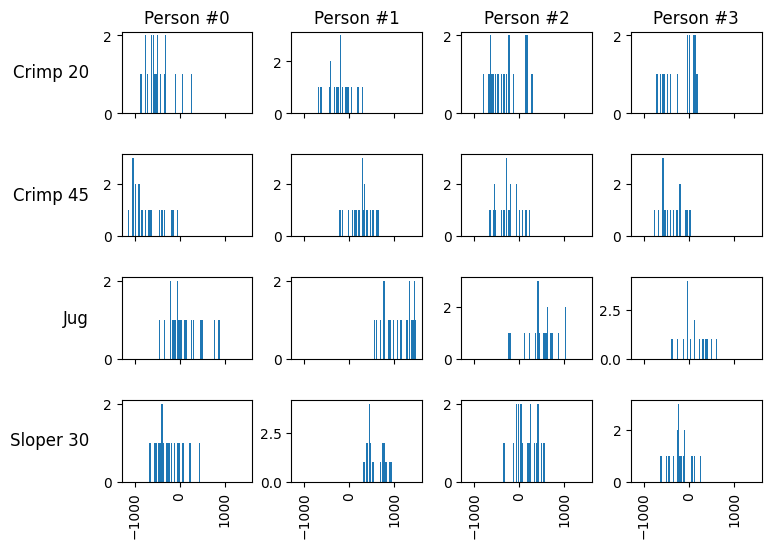

In [11]:
bin_count = 100
bins = np.arange(X.PCA1.min(), X.PCA1.max(), (X.PCA1.max() - X.PCA1.min()) / (bin_count - 1))

axes = X.PCA1.hist(
    by=[y['hold'], y['person']],
    bins=bins, layout=(len(hold_types), len(people)),
    sharex=True, figsize=(8,6))

for ax, (hold, person) in zip(axes.flatten(), [(h, p) for h in hold_types for p in people]):
    row, col = list(hold_types).index(hold), list(people).index(person)
    ax.set_title(person if row == 0 else '', fontsize=12)
    if col == 0:
        ax.annotate(hold, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 2, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=12, rotation=0)

savefig_pdf('pca-distributions')

In [12]:
hpcs = np.array(np.meshgrid(hold_types, people)).T.reshape((len(hold_types) * len(people), 2))

alpha = 0.95
threshold = (1 - alpha) / binom(len(hpcs), 2)
print('Bonferroni-corrected rejection threshold:')
print(f'  p < {threshold:.4f}  ⇔  -log(p) > {-np.log(threshold):.2f}')

Bonferroni-corrected rejection threshold:
  p < 0.0004  ⇔  -log(p) > 7.78


In [13]:
results = np.ones((len(hpcs), len(hpcs)))
desired_rejection = np.ones((len(hpcs), len(hpcs)))
for i, (hold1, name1) in enumerate(hpcs):
    for j, (hold2, name2) in enumerate(hpcs):
        if i <= j: continue
        results[i, j] = mannwhitneyu(
            X.PCA1[(y['hold'] == hold1) & (y['person'] == name1)],
            X.PCA1[(y['hold'] == hold2) & (y['person'] == name2)]).pvalue
        desired_rejection[i, j] = 0 if hold1 == hold2 else 1

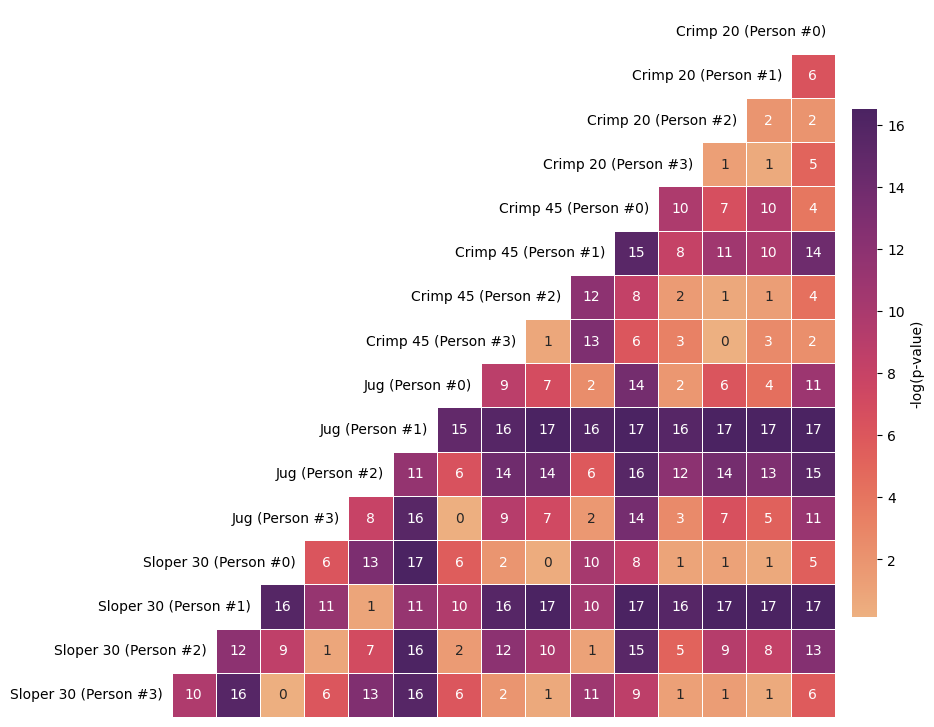

In [14]:
plt.subplots(figsize=(11, 11))
labels = [f'{pretty_str(hold)} ({pretty_str(name)})' for hold, name in hpcs]
pretty_hm(results, labels)
savefig_pdf('pairwise-ks')

Desired rejection pattern where 1 is rejection and 0 is fail to reject


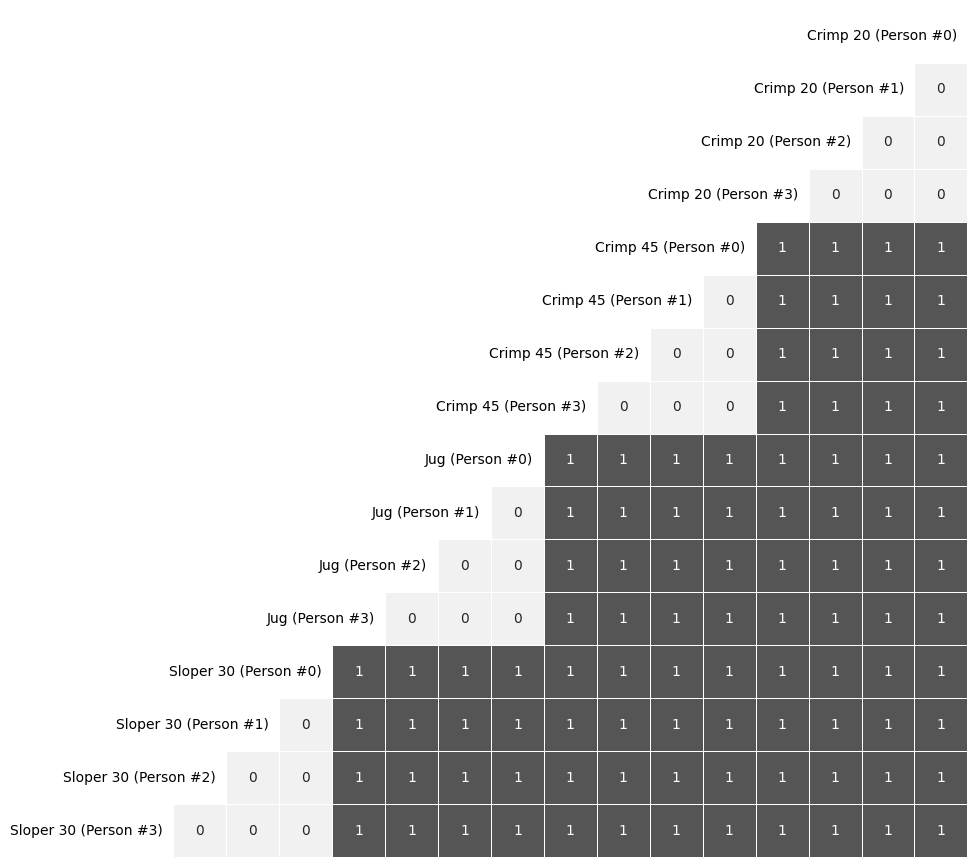

In [8]:
plt.subplots(figsize=(11, 11))
pretty_hm(desired_rejection, labels, legend=False, transform=None, cmap=sns.color_palette("light:#555", as_cmap=True))
savefig_pdf('desired-rejection')
print('Desired rejection pattern where 1 is rejection and 0 is fail to reject')